# Loading Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
import missingno as msno
import pycountry

from prophet import Prophet
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from prophet.plot import plot_plotly, plot_components_plotly

#  0. Reading in data

In [95]:
# reading in from current directory
df = pd.read_csv("nuforc_reports.csv")

# 1. Clean the data

In [96]:
df.shape

(88125, 12)

In [97]:
df.dtypes

summary            object
city               object
state              object
date_time          object
shape              object
duration           object
stats              object
report_link        object
text               object
posted             object
city_latitude     float64
city_longitude    float64
dtype: object

In [98]:
df.isna().sum()

summary              30
city                234
state              5235
date_time          1187
shape              2498
duration           3171
stats                37
report_link           0
text                 55
posted             1187
city_latitude     16112
city_longitude    16112
dtype: int64

## Extract information out of `stats` field, especially `Occurred`

In [99]:
df.loc[df['stats'].notna(), 
       'occurred'] = df.loc[df['stats'].notna(), 
                            'stats'].map(lambda x: x.split(' ')[2]+' '+x.split(' ')[3])

In [100]:
df['occurred'] = pd.to_datetime(df['occurred'], 
                                errors='coerce', 
                                dayfirst=False)

## `date_time` Conversion

In [101]:
# convert date/time columns to proper format, and sort dataset by date
df['date_time'] = pd.to_datetime(df['date_time'], 
                                 errors='coerce', 
                                 infer_datetime_format=True)

df['posted'] = pd.to_datetime(df['posted'], 
                              errors='coerce', 
                              infer_datetime_format=True)

df.sort_values(by='date_time', inplace=True)

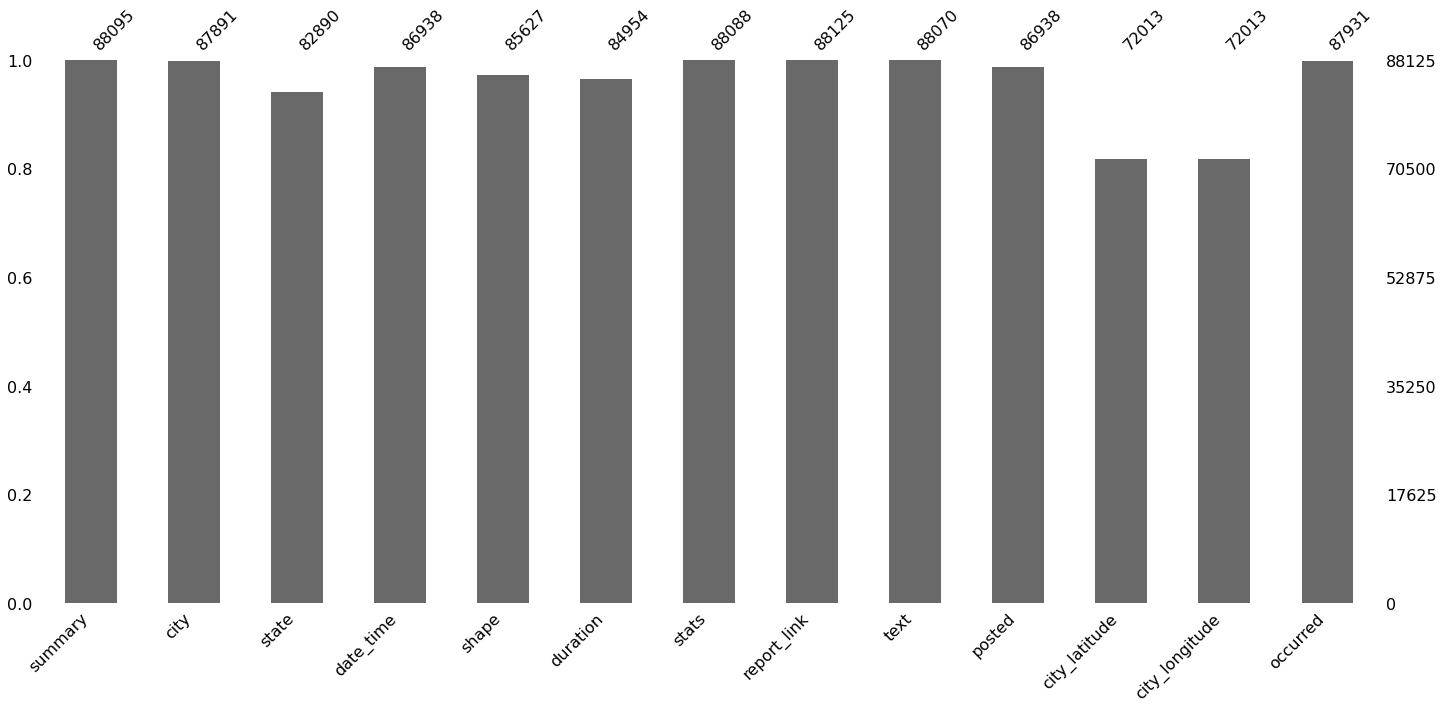

In [102]:
msno.bar(df);

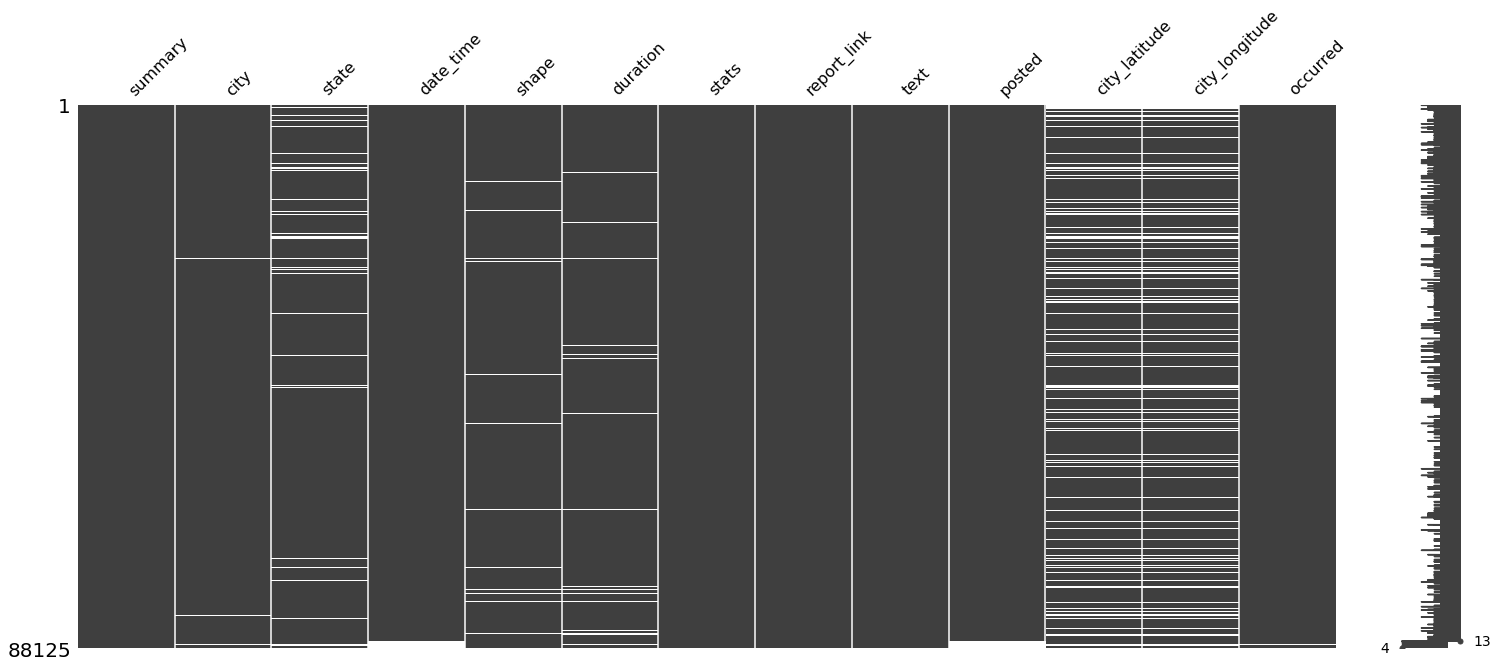

In [103]:
msno.matrix(df);

## Fill Missing `shape` data

In [104]:
df['shape'].fillna(value='unknown', 
                   inplace=True)

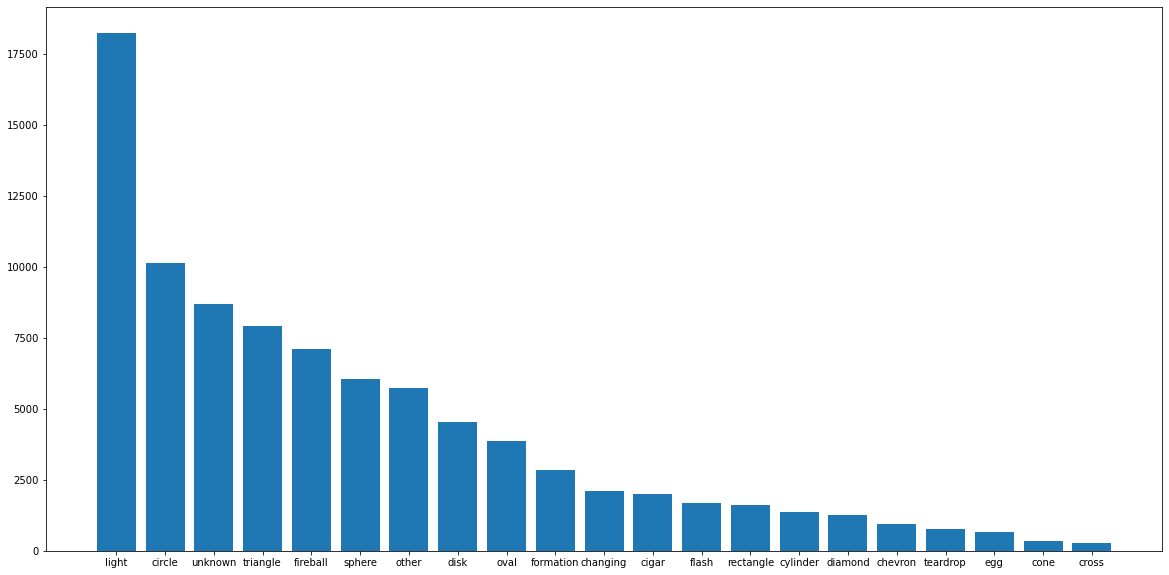

In [105]:
plt.figure(figsize=(20,10))
plt.bar(df['shape'].value_counts().index, 
        height=df['shape'].value_counts().values);

## compare `occurred` vs. `date_time`

In [106]:
df.loc[df['occurred'] != df['date_time'], ['date_time', 'occurred']].shape

(1358, 2)

Only 1,358 rows have a mismatch between the date_time provided and occured date extracted from stats field. 

**Assumption: we will utilize the date_time field as the difference is negligibly small**.

Few examples are shown below.

In [107]:
df.loc[df['occurred'] != df['date_time'], ['date_time', 'occurred']].head(20)

date_time            occurred
1576  1969-06-30 00:00:00 1969-05-30 20:30:00
78989 1970-06-01 19:00:00 1970-06-30 19:00:00
15567 1971-06-30 14:00:00 1871-06-30 14:00:00
20364 1976-04-25 21:00:00                 NaT
9201  1980-12-12 20:40:00 1880-12-12 20:40:00
36382 1986-10-24 23:00:00 1886-10-24 23:00:00
176   1986-11-03 22:00:00 2019-03-17 22:00:00
35620 1988-02-15 02:30:00 1988-02-01 02:30:00
72347 1988-05-04 01:00:00 1788-05-04 01:00:00
4860  1990-06-30 21:00:00 1790-06-30 21:00:00
71828 1993-01-02 06:00:00                 NaT
36519 1994-07-27 22:00:00                 NaT
84438 1995-12-23 00:00:00 1995-12-23 17:30:00
7884  1996-06-02 13:00:00 1896-06-02 13:00:00
37275 1997-04-17 06:00:00 1897-04-17 06:00:00
3143  1997-11-15 00:00:00 1997-11-15 20:00:00
78984 1998-06-30 00:00:00 1898-06-30 00:00:00
81531 1999-12-30 00:00:00 2018-04-04 01:13:00
704   1999-12-30 00:00:00 2021-08-09 00:00:00
85489 1999-12-30 05:30:00 2021-08-09 11:19:18

Some of these seem like typos, such as **occurred in 1790** but **date_time is 1990**. It seems the 9 was mistyped as 7, and that is the root of the error. Similar cases are seen for 1788 vs. 1988, 1886 vs. 1986. 

There are few other cases where there is some hourly difference.

In [108]:
df['diff_in_date_and_occured'] = df['date_time'] - df['occurred']

In [109]:
df['diff_in_date_and_occured'].value_counts().head(20)

0 days 00:00:00          86767
-1 days +12:00:00           16
0 days 12:00:00             15
36525 days 00:00:00         13
36524 days 00:00:00          6
1 days 00:00:00              4
-1 days +00:00:00            4
73048 days 00:00:00          2
-1 days +22:00:00            2
0 days 00:01:00              2
0 days 00:10:00              2
365 days 00:00:00            2
0 days 23:00:00              2
31 days 00:00:00             2
-11822 days +00:00:00        1
-1 days +23:29:00            1
-14 days +00:00:00           1
1454 days 00:00:00           1
-1556 days +00:00:00         1
731 days 00:00:00            1
Name: diff_in_date_and_occured, dtype: int64

In [110]:
df.drop(columns=['occurred', 'diff_in_date_and_occured'], axis=1, inplace=True)

**~98% of the cases have no difference. We are good to proceed.**

## Dropping missing rows

In [111]:
# remove rows not containing any date
df.dropna(subset=['date_time'], 
          inplace=True, 
          axis=0)

# set date/time as index
df.set_index('date_time', 
             inplace=True)

In [112]:
df.shape

(86938, 11)

## Extracting `duration` from free-style entry field

In [113]:
df.loc[df['duration'].notna(), 'min_duration'] = df.loc[df['duration'].notna(), 'duration'].map(lambda x: x if 'min' in x.lower() else 0)
df.loc[df['duration'].notna(), 'sec_duration'] = df.loc[df['duration'].notna(), 'duration'].map(lambda x: x if 'sec' in x.lower() else 0)
df.loc[df['duration'].notna(), 'hour_duration'] = df.loc[df['duration'].notna(), 'duration'].map(lambda x: x if 'hour' in x.lower() or 'hr' in x.lower() else 0)

In [114]:
df.loc[df['duration'].notna(), 'min_duration'] = df.loc[df['duration'].notna(), 'min_duration'].str.extract('(\d+)').values
df.loc[df['duration'].notna(), 'sec_duration'] = df.loc[df['duration'].notna(), 'sec_duration'].str.extract('(\d+)').values
df.loc[df['duration'].notna(), 'hour_duration'] = df.loc[df['duration'].notna(), 'hour_duration'].str.extract('(\d+)').values

In [115]:
df.loc[df['duration'].notna(), 'min_duration'] = df.loc[df['duration'].notna(), 'min_duration'].astype('float')
df.loc[df['duration'].notna(), 'sec_duration'] = df.loc[df['duration'].notna(), 'sec_duration'].astype('float')
df.loc[df['duration'].notna(), 'hour_duration'] = df.loc[df['duration'].notna(), 'hour_duration'].astype('float')

In [116]:
df.loc[df['duration'].notna(), 'min_duration'] = df.loc[df['duration'].notna(), 'min_duration'] * 60
df.loc[df['duration'].notna(), 'hour_duration'] = df.loc[df['duration'].notna(), 'hour_duration'] * 3600

In [117]:
df['duration_cleaned'] = df['min_duration'].fillna(0) + df['hour_duration'].fillna(0) + df['sec_duration'].fillna(0)
df['duration_cleaned'].replace(0, df['duration_cleaned'].median(), inplace=True)

In [118]:
df.drop(columns=['min_duration', 
                 'sec_duration', 
                 'hour_duration'], 
        inplace=True)

In [119]:
df.loc[df['duration_cleaned']>df['duration_cleaned'].quantile(0.95), 
       'duration_cleaned'] = df['duration_cleaned'].quantile(0.95)

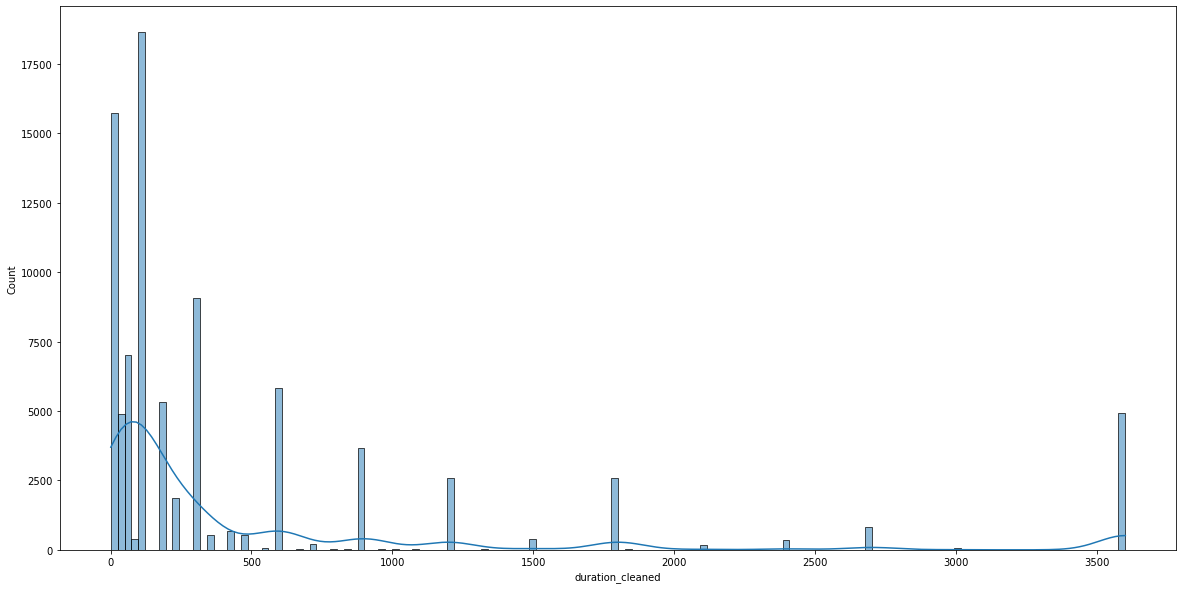

In [120]:
plt.figure(figsize=(20,10))
sns.histplot(data=df, 
             x='duration_cleaned', 
             kde=True, 
             element='bars', 
             stat='count');

## Get `country` from `city` and `state`

In [121]:
# US states
state_abbr = []
for i in pycountry.subdivisions.get(country_code='US'):
    state_abbr.append(i.code[3:])

In [122]:
# Canada states
can_state_abbr = []
for i in pycountry.subdivisions.get(country_code='CA'):
    can_state_abbr.append(i.code[3:])

In [123]:
# pass 1: fill country for United States
df.loc[df['state'].notna(), 'country'] = df.loc[df['state'].notna(), 'state'].map(lambda x: 
                                                                                  'United States' if x in state_abbr 
                                                                                  else 'Other')

In [124]:
# pass 2: fill country for Canada
df.loc[(df['state'].notna()) & 
       (df['country'] != 'United States'), 'country'] = df.loc[(df['state'].notna()) & 
                                                               (df['country'] != 'United States'), 
                                                               'state'].map(lambda x: 
                                                                            'Canada' if x in can_state_abbr 
                                                                            else 'Other')

In [125]:
# pass 3: extract country for those that have mentioned in city
df.loc[(df['country'].isna()) & 
       (df['city'].notna()), 'country'] = df.loc[(df['country'].isna()) & 
                                                 (df['city'].notna()), 'city'].map(lambda x: 
                                                                                   x.split('(')[-1].strip(')'))

In [126]:
# correct UK as per ISO naming
df['country'] = df['country'].map(lambda x: 'United Kingdom' if x == 'UK/England' else x)

In [127]:
# get country names from ISO to compare with provided list
country_names = []
for i in pycountry.countries:
    country_names.append(i.name)

In [128]:
# pass 4: check if country name is according to ISO convention
df['country'] = df['country'].map(lambda x: x if x in country_names else 'Other')

In [129]:
# clean city names - remove any text in bracket
df.loc[df['city'].notna(), 'city'] = df.loc[df['city'].notna(), 'city'].map(lambda x: x.split('(')[0])

In [130]:
# export cleaned data to csv
# df.to_csv("nuforc_cleaned.csv")

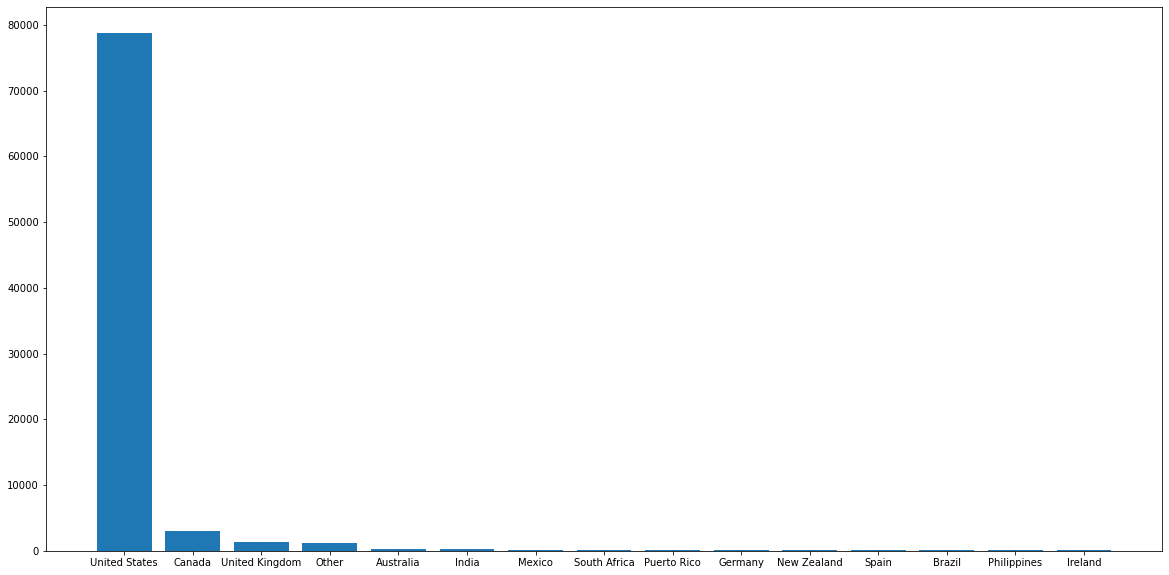

In [133]:
plt.figure(figsize=(20,10))
plt.bar(df['country'].value_counts().index[0:15], 
        df['country'].value_counts().values[0:15]);

In [34]:
df.isna().sum()

summary                29
city                  207
state                5107
shape                   0
duration             3068
stats                  36
report_link             0
text                   54
posted                  0
city_latitude       15754
city_longitude      15754
duration_cleaned        0
country                 0
dtype: int64

In [35]:
df.shape

(86938, 13)

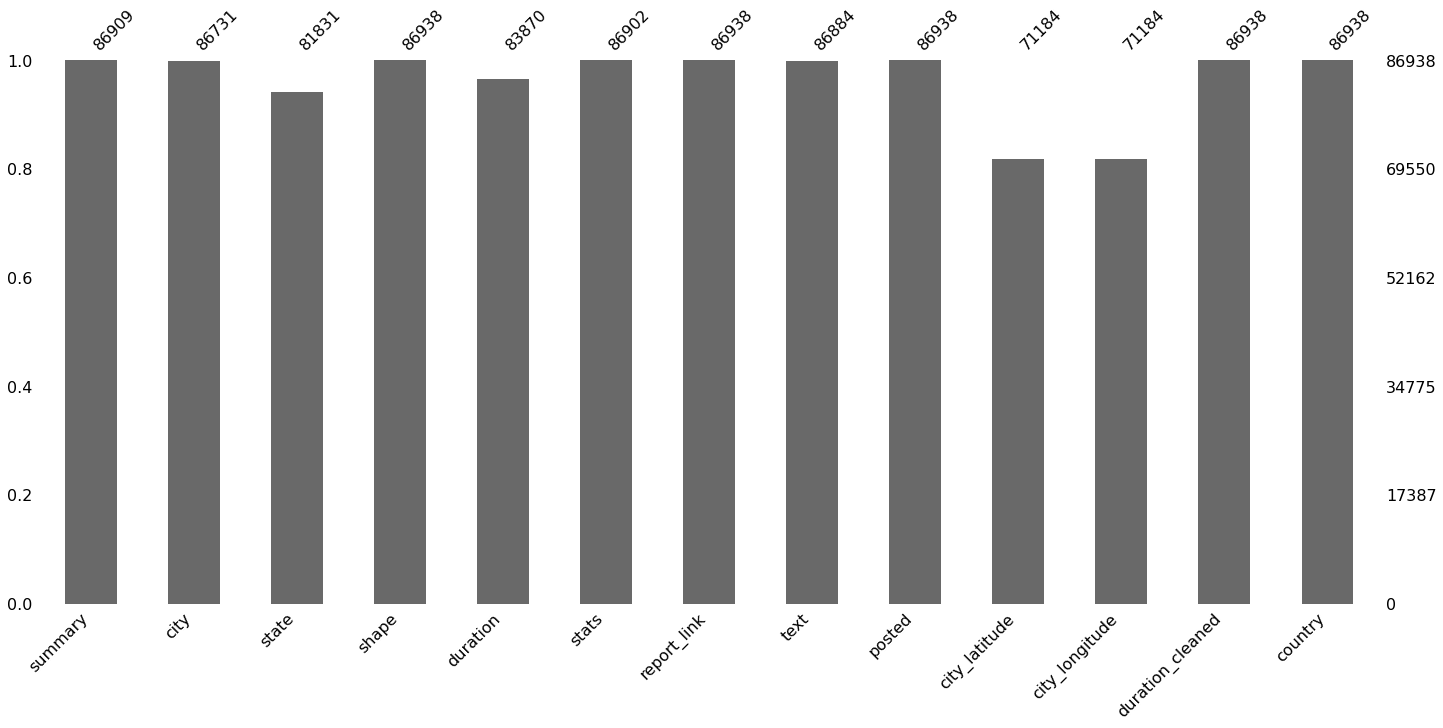

In [36]:
msno.bar(df);

## Get Wordcloud for `summary` field

In [187]:
# initiate the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', 
                             ngram_range = (1,1), 
                             max_df = 1, 
                             min_df = .0001)

In [188]:
# create corpus from summary field
corpus = df.loc[df['summary'].notna(), 'summary'].values
corpus_combined = ' '.join(corpus)

In [189]:
# merge into a single document
new_corpus = []
new_corpus.append(corpus_combined)

In [190]:
# fit the vectorizer on corpus data
X = vectorizer.fit_transform(new_corpus)
feature_names = vectorizer.get_feature_names()

# get dataframe representation of TF-IDF
dense = X.todense()
denselist = dense.tolist()
df_1 = pd.DataFrame(denselist, columns=feature_names)

data = df_1.transpose()

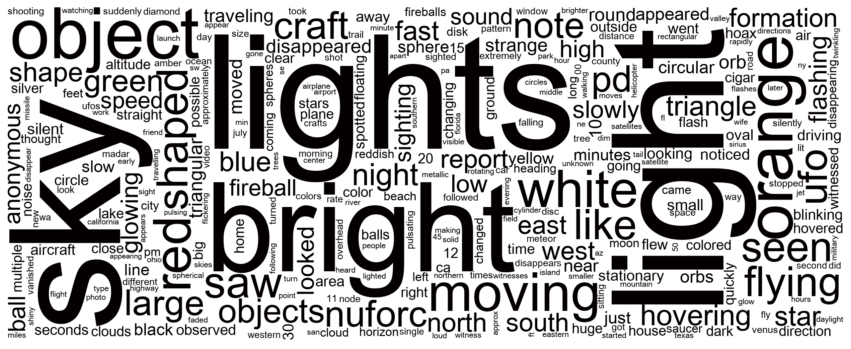

In [198]:
### plot the wordcloud ###

# change the value to black
def black_color_func(word, 
                     font_size, 
                     position,
                     orientation,
                     random_state=None, 
                     **kwargs):
    return("hsl(0,100%, 1%)")

# set the wordcloud background color to white
# set max_words to 300
# set width and height to higher quality

wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', 
                      background_color="white", 
                      width=2500, 
                      height=1000, 
                      max_words=300).generate_from_frequencies(data[0])

# set the word color to black
wordcloud.recolor(color_func = black_color_func)

# set the figsize
plt.figure(figsize=[15,10])

# plot the wordcloud
plt.imshow(wordcloud, 
           interpolation="bilinear")

# remove plot axes
plt.axis("off");

# 2. Forecast January 2020 
# (using Facebook's Prophet library)

In [134]:
# preparing forecasting dataframe to be read in by Prophet
# granularity is monthly
# only use 2006 onwards since data before that is too sparse

forecast = df.resample('M')[['shape']].count()
forecast = forecast.loc['2006':]

forecast.reset_index(inplace=True)
forecast.rename(columns={'date_time': 'ds', 'shape': 'y'}, inplace=True)

In [135]:
# instantiate Prophet object and then fit it on data
m = Prophet()
m.fit(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [136]:
# make future dataframe with January 2020 as the last month to forecast
future = m.make_future_dataframe(periods=1)
future.tail()

ds
164 2019-09-30
165 2019-10-31
166 2019-11-30
167 2019-12-31
168 2020-01-01

In [137]:
forecast = m.predict(future)

ds        yhat  yhat_lower  yhat_upper
164 2019-09-30  458.480571  316.030496  603.014064
165 2019-10-31  443.917922  295.251425  592.930049
166 2019-11-30  398.856927  250.562872  553.741134
167 2019-12-31  319.213323  173.087019  464.078921
168 2020-01-01  327.060172  187.547803  470.211759

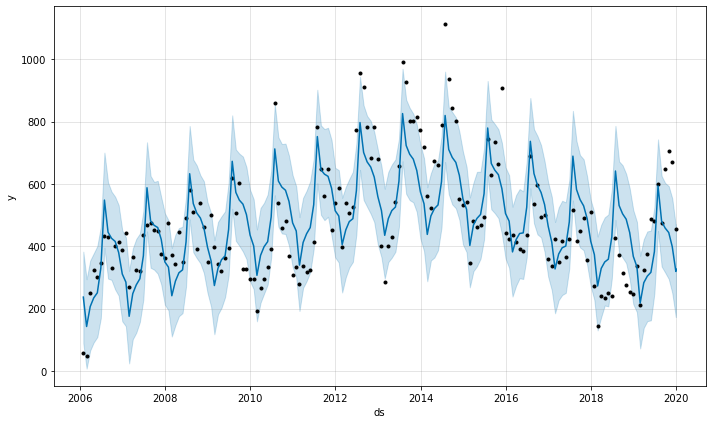

In [138]:
fig1 = m.plot(forecast)

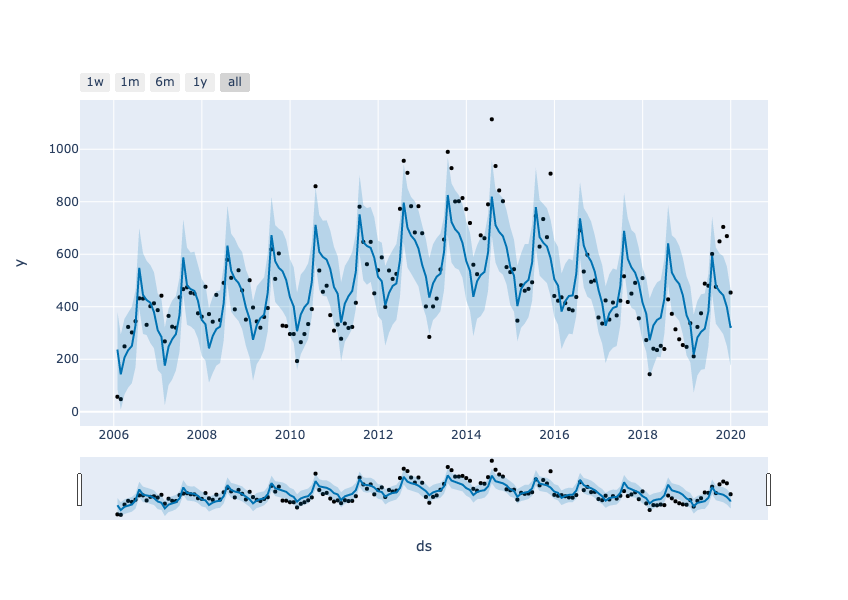

In [139]:
plot_plotly(m, forecast)